#Import

In [2]:
import csv
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

#Codigo

In [3]:
from numba import njit
import numpy as np
import random

def generar_vecino_por_sublista(solucion, s):
    n = len(solucion)
    inicio = random.randint(0, n - 1)
    fin = (inicio + s) % n

    solucion = list(solucion)

    if inicio <= fin:
        sublista = solucion[inicio:fin]
        random.shuffle(sublista)
        nueva_solucion = solucion[:inicio] + sublista + solucion[fin:]
    else:
        sublista = solucion[inicio:] + solucion[:fin]
        random.shuffle(sublista)
        nueva_solucion = sublista[-fin:] + solucion[fin:inicio] + sublista[:-fin]

    return np.array(nueva_solucion)


def vns(n, A, B, blmax=10, kmax=5):
    # Paso 1: Generar solución inicial aleatoria
    S = np.random.permutation(n)
    C = funcionObjetivo(S, A, B)
    total_evaluaciones = 0
    historial_costes = [C]

    bl = 0  # contador de veces que se aplica búsqueda local
    k = 1   # entorno inicial

    while bl < blmax:
        if k > kmax:
           k=1

        # Obtener tamaño de sublista según k: s = n / (9 - k)
        s = max(1, n // (9 - k))

        # Paso 2: Generar vecino S' aplicando Ek
        S_prim = generar_vecino_por_sublista(S, s)

        # Paso 3: Aplicar búsqueda local a S'
        S_dos_prim, C_dos_prim, evaluaciones, _ = busquedaLocalPrimerVecino(n, A, B,S_prim,funcionObjetivo(S_prim, A, B))
        total_evaluaciones += evaluaciones
        bl += 1  # se ha aplicado una búsqueda local


        # Paso 4: Si mejora, aceptar y reiniciar k
        if C_dos_prim < C:
            S = S_dos_prim
            C = C_dos_prim
            k = 1
        else:
            k += 1
        historial_costes.append(C)
    return S, C, total_evaluaciones, historial_costes
@njit
def funcionObjetivo(S, A, B):
    coste = 0
    n = len(S)
    for i in range(n):
        for j in range(n):
            coste += A[i, j] * B[S[i], S[j]]
    return coste



def leerFichero(file_path):
    with open(file_path, 'r') as f:
        n = int(f.readline().strip())
        lines = [line.strip() for line in f if line.strip() != '']
        all_numbers = []
        for line in lines:
            all_numbers.extend(map(int, line.split()))

        total_vals = n * n
        A_vals = all_numbers[:total_vals]
        B_vals = all_numbers[total_vals:2 * total_vals]

        A = np.array(A_vals, dtype=np.int64).reshape((n, n))
        B = np.array(B_vals, dtype=np.int64).reshape((n, n))

    return n, A, B

def busquedaLocalPrimerVecino(n, A, B,Sact,Cact):

    contador = 1
    historial_costes = [Cact]

    while True:
        MejorV = None
        MejorVC = Cact
        mejora_encontrada = False
        lista = np.random.permutation(n)

        for i in range(n):
            for j in range(i + 1, n):
                vecino = Sact.copy()
                vecino[lista[i]], vecino[lista[j]] = vecino[lista[j]], vecino[lista[i]]
                Cvec = funcionObjetivo(vecino, A, B)
                contador += 1

                if Cvec < MejorVC:
                    MejorV = vecino
                    MejorVC = Cvec
                    mejora_encontrada = True
                    break
            if mejora_encontrada:
                break
        historial_costes.append(Cact)
        if mejora_encontrada:
            Sact = MejorV
            Cact = MejorVC

        else:
            break

    return Sact, Cact, contador, historial_costes
######
def grasp(n, A, B, l=None, iteraciones=5):
    if l is None:
        l = max(1, int(0.1 * n))  # Al menos 1 para evitar listas vacías

    mejor_solucion = None
    mejor_coste = float('inf')
    historial_costes = []
    total_evaluaciones = 0

    for _ in range(iteraciones):
        # Construir solución Greedy Aleatorizada
        solucion = construir_solucion_grasp(n, A, B, l)

        # Aplicar búsqueda local (primer mejor vecino)
        solucion_opt, coste_opt, evaluaciones, _ = busquedaLocalPrimerVecino(n, A, B,solucion,funcionObjetivo(solucion, A, B))

        total_evaluaciones += evaluaciones

        if coste_opt < mejor_coste:
            mejor_solucion = solucion_opt
            mejor_coste = coste_opt

        historial_costes.append(mejor_coste)

    return mejor_solucion, mejor_coste, total_evaluaciones, historial_costes


def construir_solucion_grasp(n, A, B, l):
    unidades_disponibles = list(range(n))
    localizaciones_disponibles = list(range(n))
    asignacion = [-1] * n

    for _ in range(n):
        # Cálculo de "potencial"
        potencial_unidades = calcular_potencial(A, unidades_disponibles)
        potencial_localizaciones = calcular_potencial(B, localizaciones_disponibles)

        # Obtener top-l unidades y localizaciones con mayor potencial
        top_unidades = sorted(unidades_disponibles, key=lambda x: -potencial_unidades[x])[:l]
        top_localizaciones = sorted(localizaciones_disponibles, key=lambda x: -potencial_localizaciones[x])[:l]

        # Elegir aleatoriamente uno de cada lista
        unidad = random.choice(top_unidades)
        localizacion = random.choice(top_localizaciones)

        asignacion[unidad] = localizacion

        unidades_disponibles.remove(unidad)
        localizaciones_disponibles.remove(localizacion)

    # Transformar asignación a permutación: índice -> unidad, valor -> localización
    solucion = [0] * n
    for unidad, localizacion in enumerate(asignacion):
        solucion[unidad] = localizacion

    return solucion


def calcular_potencial(matriz, elementos):
    # Suma de pesos de la fila para medir potencial
    return {i: np.sum(matriz[i]) for i in elementos}






##########

def mutar_sublista(solucion, s):
    n = len(solucion)
    inicio = random.randint(0, n - 1)
    fin = (inicio + s) % n

    solucion = list(solucion)  # convertir a lista para manipular fácilmente

    if inicio <= fin:
        sublista = solucion[inicio:fin]
        random.shuffle(sublista)
        nueva_solucion = solucion[:inicio] + sublista + solucion[fin:]
    else:
        # Sublista cíclica
        sublista = (solucion[inicio:] + solucion[:fin])
        random.shuffle(sublista)
        nueva_solucion = sublista[-fin:] + solucion[fin:inicio] + sublista[:-fin]

    return np.array(nueva_solucion)  # devolver como array para seguir trabajandod

def ils(n, A, B, iteraciones=10):
    # Paso 1: generar solución inicial aleatoria
    mejor_solucion = np.random.permutation(n)
    mejor_coste = funcionObjetivo(mejor_solucion, A, B)

    historial_costes = [mejor_coste]
    total_evaluaciones = 0

    # Paso 2: aplicar búsqueda local sobre la inicial
    mejor_solucion, mejor_coste, evaluaciones, _ = busquedaLocalPrimerVecino(n, A, B,mejor_solucion,mejor_coste)
    total_evaluaciones += evaluaciones

    for _ in range(iteraciones - 1):  # ya hicimos 1 arriba
        # Paso 3: mutación (sublista aleatoria)
        s = n // 4
        solucion_mutada = mutar_sublista(mejor_solucion, s)

        # Paso 4: búsqueda local sobre solución mutada
        nueva_solucion, nuevo_coste, evaluaciones, _ = busquedaLocalPrimerVecino(n, A, B,mejor_solucion,mejor_coste)
        total_evaluaciones += evaluaciones

        # Paso 5: criterio del mejor
        if nuevo_coste < mejor_coste:
            mejor_solucion = nueva_solucion
            mejor_coste = nuevo_coste

        historial_costes.append(mejor_coste)

    return mejor_solucion, mejor_coste, total_evaluaciones, historial_costes

def ejecutarExperimentoVns(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs = []
    histories = []
    algoritmo = "VNS"

    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        solucion, coste, evaluaciones, hc = vns(n, A, B)
        best_costs.append(coste)

        evs.append(evaluaciones)
        histories.append(hc)

        plt.plot(hc, label=f"Semilla {seed}")
        with open("/content/drive/MyDrive/Datos/resultados.csv", "a", newline='') as f:
          writer = csv.writer(f)
          writer.writerow([
        algoritmo,
        n,
        seed,
        coste,
        evaluaciones,
        ','.join(map(str, hc))  # convierte la lista en string
    ])
        print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}")


    media = np.mean(best_costs)
    desviacion = np.std(best_costs)


    print("\nResumen del experimento :")

    mejor_coste = min(best_costs)


    varianza = np.var(best_costs)

    # Error Relativo (RE)
    error_relativo = (media - mejor_coste) / mejor_coste * 100

    # Coeficiente de Variación (CV)
    coef_variacion = desviacion / media * 100

# Mostrar resultados
    print(f"Mejor coste: {mejor_coste}")
    print(f"Media: {media:.2f}")
    print(f"Desviación típica: {desviacion:.2f}")
    print(f"Varianza: {varianza:.2f}")
    print(f"Error Relativo (RE): {error_relativo:.2f}%")
    print(f"Coeficiente de Variación (CV): {coef_variacion:.2f}%")

    plt.title("Evolución del coste ")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return best_costs, evs, histories

def ejecutarExperimentoIls(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs = []
    histories = []
    algoritmo = "ILS"

    plt.figure(figsize=(10, 6))

    seed=seeds[0]
    random.seed(seed)
    np.random.seed(seed)

    solucion, coste, evaluaciones, hc = ils(n, A, B)
    best_costs.append(coste)

    evs.append(evaluaciones)
    histories.append(hc)

    plt.plot(hc, label=f"Semilla {seed}")
    with open("/content/drive/MyDrive/Datos/resultados.csv", "a", newline='') as f:
          writer = csv.writer(f)
          writer.writerow([
        algoritmo,
        n,
        seed,
        coste,
        evaluaciones,
        ','.join(map(str, hc))  # convierte la lista en string
    ])
    print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}")


    print("\nResumen del experimento :")

    mejor_coste = min(best_costs)
# Mostrar resultados
    print(f"Mejor coste: {mejor_coste}")


    plt.title("Evolución del coste ")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return best_costs, evs, histories


def ejecutarExperimentoGrasp(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs = []
    histories = []
    algoritmo = "GRASP"

    plt.figure(figsize=(10, 6))

    seed=seeds[0]
    random.seed(seed)
    np.random.seed(seed)

    solucion, coste, evaluaciones, hc = grasp(n, A, B)
    best_costs.append(coste)

    evs.append(evaluaciones)
    histories.append(hc)

    plt.plot(hc, label=f"Semilla {seed}")
    with open("/content/drive/MyDrive/Datos/resultados.csv", "a", newline='') as f:
          writer = csv.writer(f)
          writer.writerow([
        algoritmo,
        n,
        seed,
        coste,
        evaluaciones,
        ','.join(map(str, hc))  # convierte la lista en string
    ])
    print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}")


    print("\nResumen del experimento :")

    mejor_coste = min(best_costs)
# Mostrar resultados
    print(f"Mejor coste: {mejor_coste}")


    plt.title("Evolución del coste ")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return best_costs, evs, histories
seeds = [42, 9914, 123459, 5444663, 33893]

In [ ]:
with open("/content/drive/MyDrive/Datos/resultados.csv", "w", newline='') as f:
          writer = csv.writer(f)
          writer.writerow(["Algoritmo", "Tamaño", "Seed", "Coste", "Evaluaciones", "Historial"])

Ejecución 42: Mejor costo encontrado = 380148498, Evaluaciones = 11525
Ejecución 9914: Mejor costo encontrado = 348161445, Evaluaciones = 12170
Ejecución 123459: Mejor costo encontrado = 348469470, Evaluaciones = 13138
Ejecución 5444663: Mejor costo encontrado = 347673303, Evaluaciones = 11285
Ejecución 33893: Mejor costo encontrado = 346131335, Evaluaciones = 13076

Resumen del experimento :
Mejor coste: 346131335
Media: 354116810.20
Desviación típica: 13040660.99
Varianza: 170058838984568.56
Error Relativo (RE): 2.31%
Coeficiente de Variación (CV): 3.68%


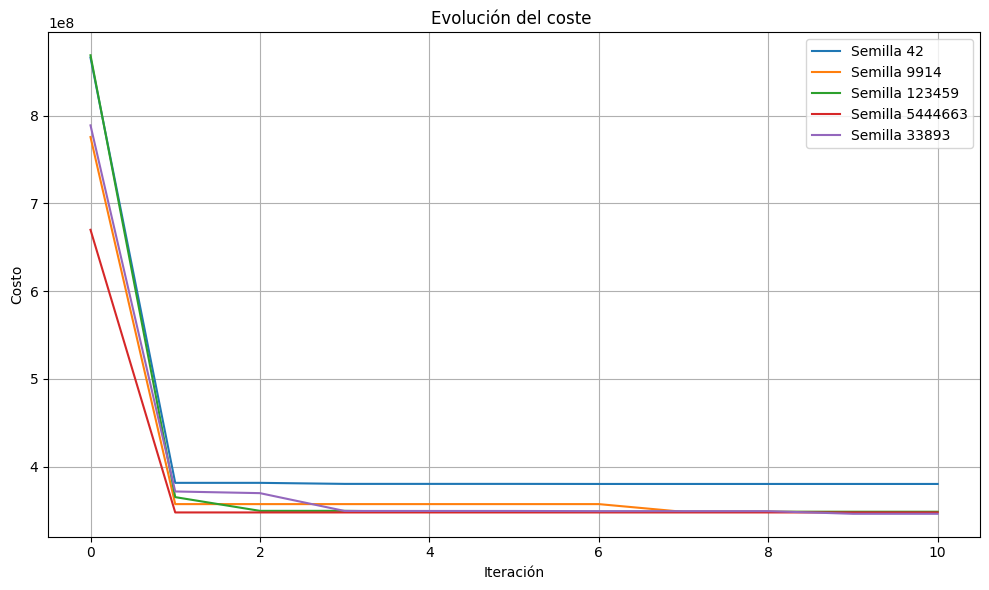

Ejecución 42: Mejor costo encontrado = 116724, Evaluaciones = 284064
Ejecución 9914: Mejor costo encontrado = 116444, Evaluaciones = 303506
Ejecución 123459: Mejor costo encontrado = 116524, Evaluaciones = 284527
Ejecución 5444663: Mejor costo encontrado = 116470, Evaluaciones = 280482
Ejecución 33893: Mejor costo encontrado = 116794, Evaluaciones = 297425

Resumen del experimento :
Mejor coste: 116444
Media: 116591.20
Desviación típica: 141.16
Varianza: 19927.36
Error Relativo (RE): 0.13%
Coeficiente de Variación (CV): 0.12%


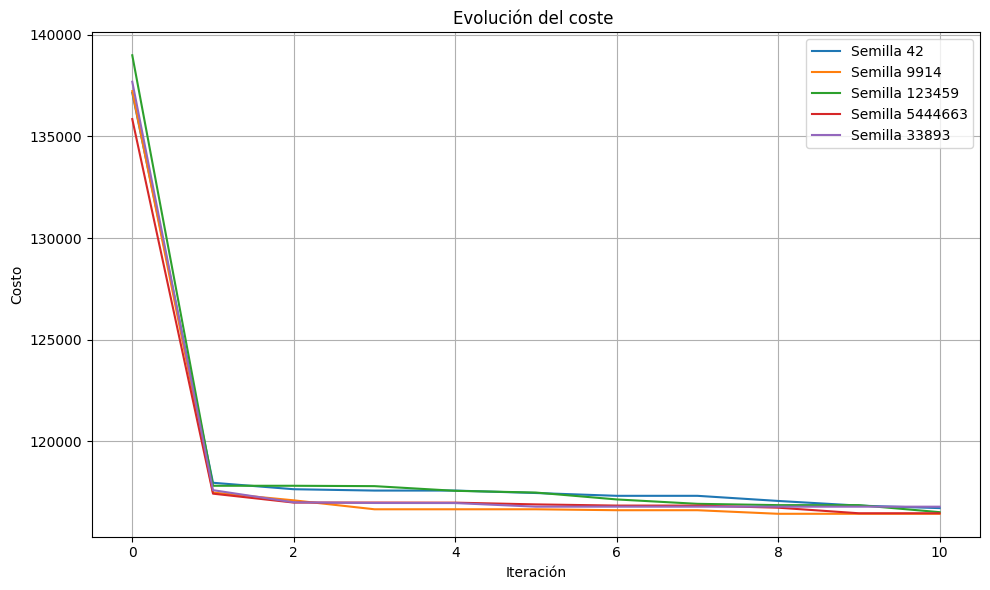

Ejecución 42: Mejor costo encontrado = 506254758, Evaluaciones = 1453181
Ejecución 9914: Mejor costo encontrado = 505958913, Evaluaciones = 1566909
Ejecución 123459: Mejor costo encontrado = 510185226, Evaluaciones = 1447389
Ejecución 5444663: Mejor costo encontrado = 509303617, Evaluaciones = 1543508
Ejecución 33893: Mejor costo encontrado = 508591145, Evaluaciones = 1753020

Resumen del experimento :
Mejor coste: 505958913
Media: 508058731.80
Desviación típica: 1674439.67
Varianza: 2803748204653.36
Error Relativo (RE): 0.42%
Coeficiente de Variación (CV): 0.33%


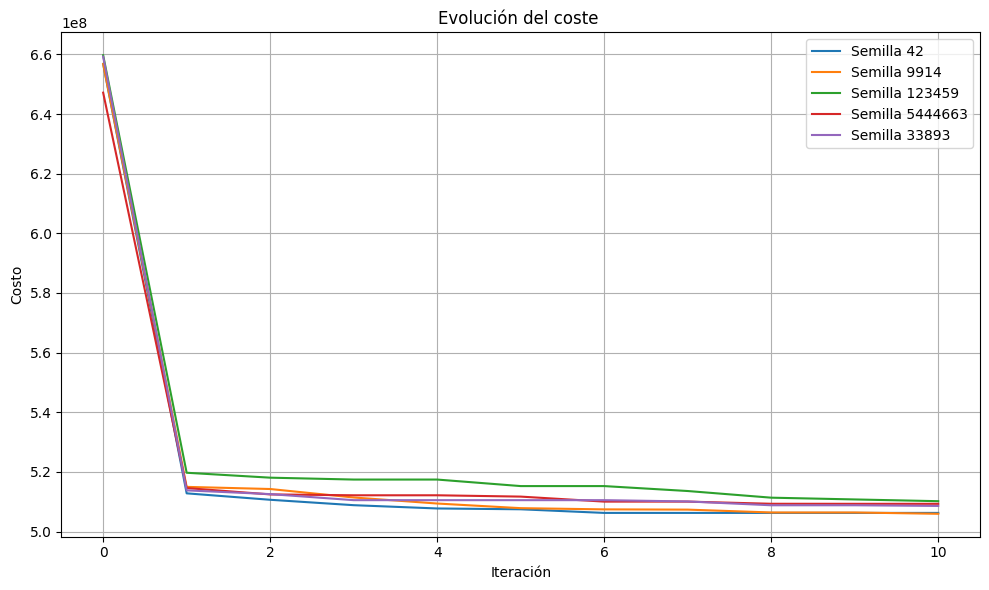

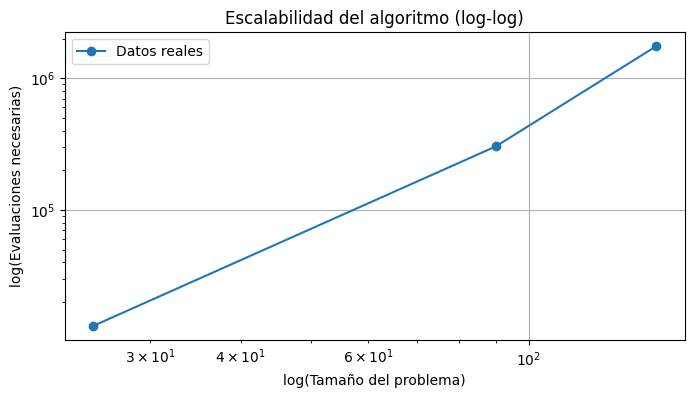

Pendiente (β) = 2.6772
Intercepto (α) = 0.3482


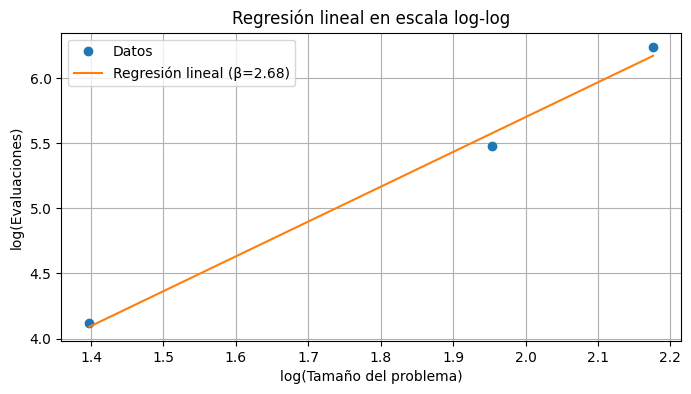

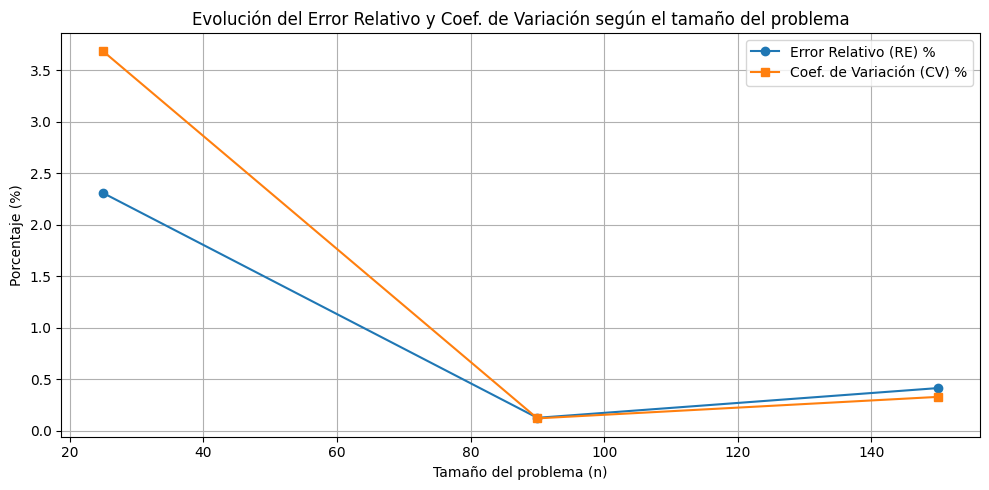

In [ ]:
b1,e1,h1=ejecutarExperimentoVns('/content/drive/MyDrive/Datos/tai25b.dat', seeds)
b2,e2,h2=ejecutarExperimentoVns('/content/drive/MyDrive/Datos/sko90.dat', seeds)
b3,e3,h3=ejecutarExperimentoVns('/content/drive/MyDrive/Datos/tai150b.dat', seeds)
tamaños = np.array([25, 90,150])
# Número de evaluaciones necesarias (ejemplo ficticio)
evaluaciones =[]
evaluaciones.append( max(e1))
evaluaciones.append( max(e2))
evaluaciones.append( max(e3))
# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.loglog(tamaños, evaluaciones, 'o-', label='Datos reales')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones necesarias)')
plt.title('Escalabilidad del algoritmo (log-log)')
plt.grid(True)
plt.legend()
plt.show()

log_sizes = np.log10(tamaños)
log_evals = np.log10(evaluaciones)

# Regresión lineal en escala log-log
slope, intercept = np.polyfit(log_sizes, log_evals, 1)
print(f"Pendiente (β) = {slope:.4f}")
print(f"Intercepto (α) = {intercept:.4f}")

# Para graficar la recta ajustada
x_fit = np.linspace(min(log_sizes), max(log_sizes), 100)
y_fit = slope * x_fit + intercept

# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.plot(log_sizes, log_evals, 'o', label='Datos')
plt.plot(x_fit, y_fit, '-', label=f'Regresión lineal (β={slope:.2f})')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones)')
plt.title('Regresión lineal en escala log-log')
plt.legend()
plt.grid(True)
plt.show()

mejores = np.array([min(b1), min(b2), min(b3)])
medias = np.array([np.mean(b1), np.mean(b2), np.mean(b3)])
stds = np.array([np.std(b1), np.std(b2), np.std(b3)])

# Cálculo de métricas
error_relativo = (medias - mejores) / mejores  # como proporción
cv = stds / medias  # como proporción

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(tamaños, error_relativo * 100, 'o-', label='Error Relativo (RE) %')
plt.plot(tamaños, cv * 100, 's-', label='Coef. de Variación (CV) %')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Porcentaje (%)')
plt.title('Evolución del Error Relativo y Coef. de Variación según el tamaño del problema')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ejecución 42: Mejor costo encontrado = 369917567, Evaluaciones = 4062

Resumen del experimento :
Mejor coste: 369917567


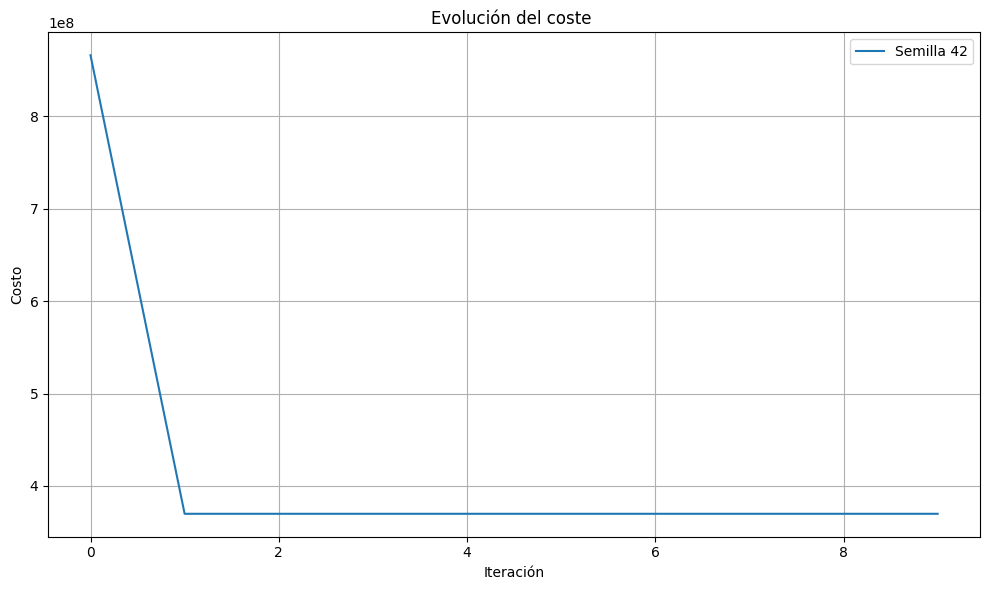

Ejecución 42: Mejor costo encontrado = 117260, Evaluaciones = 80367

Resumen del experimento :
Mejor coste: 117260


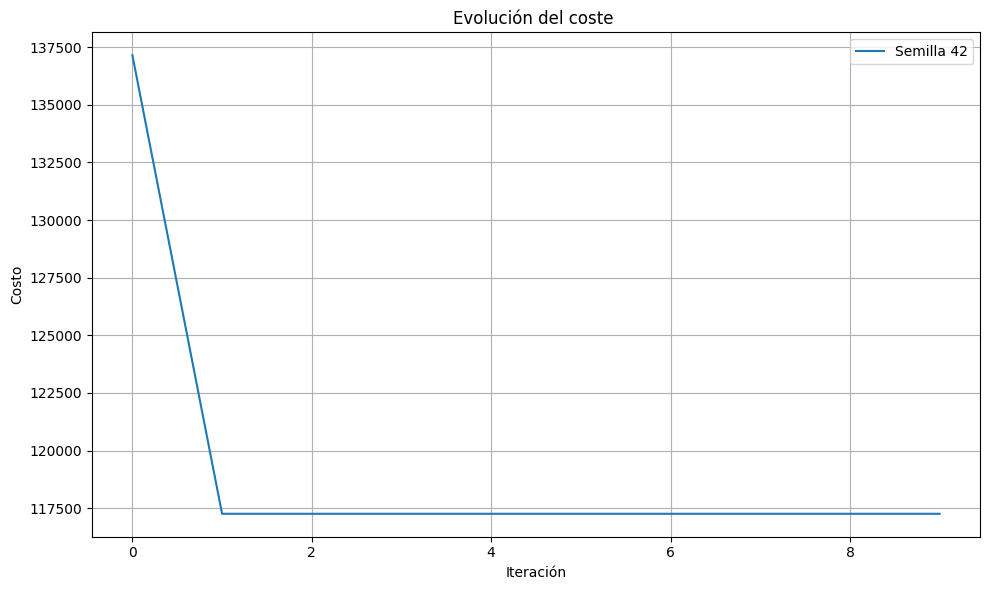

Ejecución 42: Mejor costo encontrado = 511655932, Evaluaciones = 305493

Resumen del experimento :
Mejor coste: 511655932


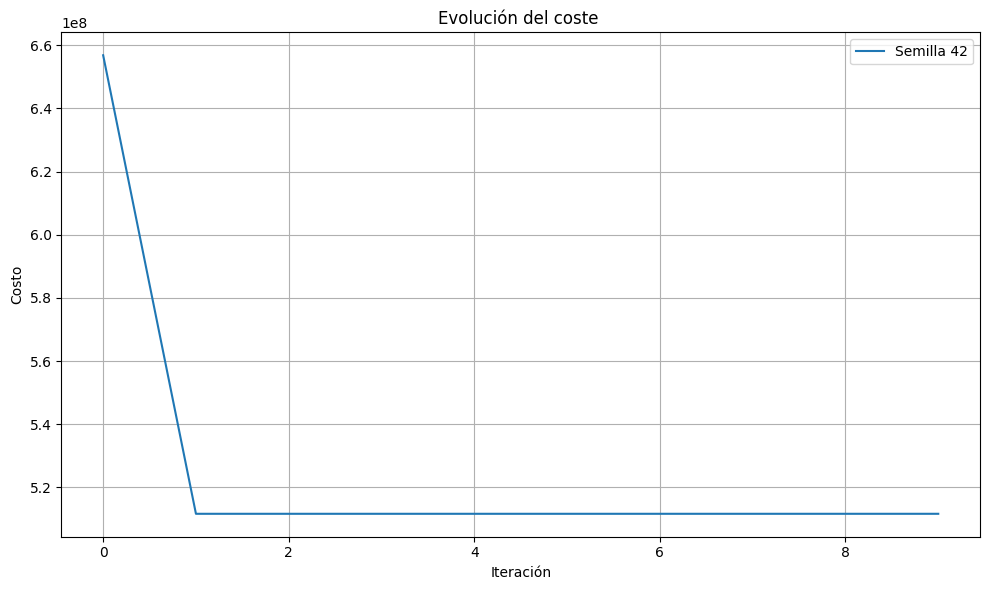

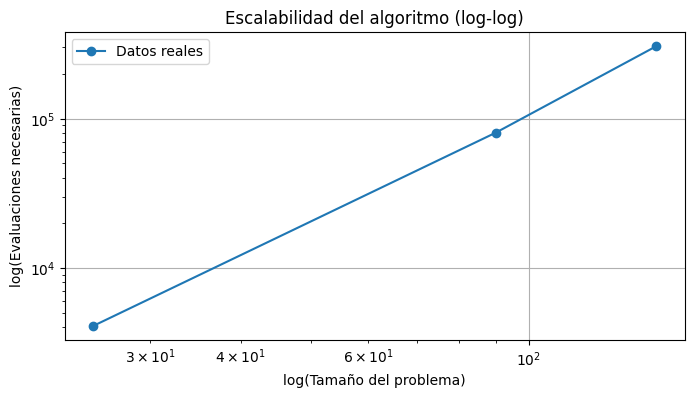

Pendiente (β) = 2.3956
Intercepto (α) = 0.2518


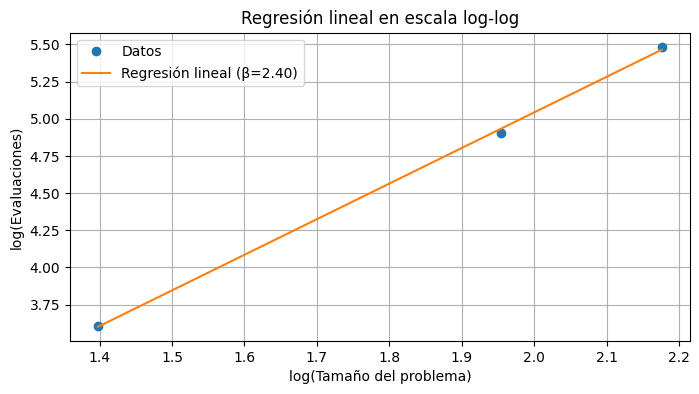

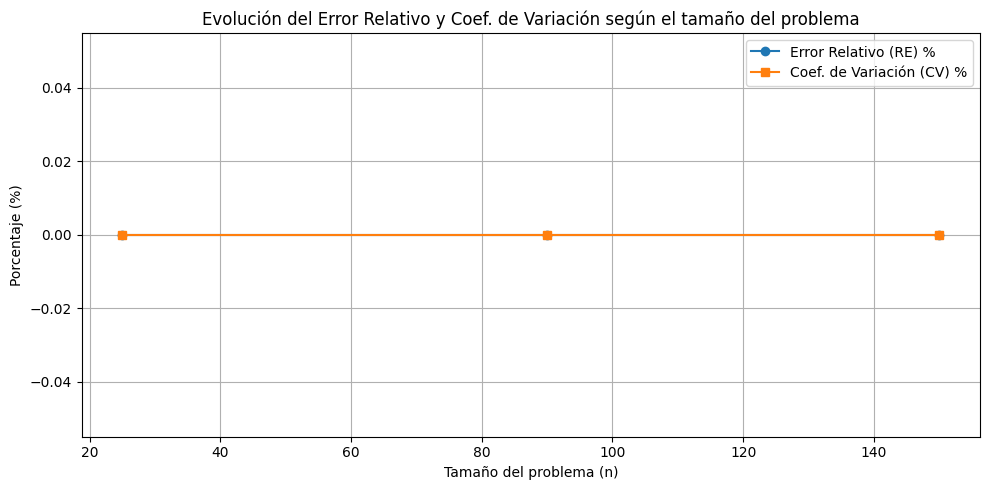

In [ ]:
b1,e1,h1=ejecutarExperimentoIls('/content/drive/MyDrive/Datos/tai25b.dat', seeds)
b2,e2,h2=ejecutarExperimentoIls('/content/drive/MyDrive/Datos/sko90.dat', seeds)
b3,e3,h3=ejecutarExperimentoIls('/content/drive/MyDrive/Datos/tai150b.dat', seeds)
tamaños = np.array([25, 90,150])
# Número de evaluaciones necesarias (ejemplo ficticio)
evaluaciones =[]
evaluaciones.append( max(e1))
evaluaciones.append( max(e2))
evaluaciones.append( max(e3))
# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.loglog(tamaños, evaluaciones, 'o-', label='Datos reales')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones necesarias)')
plt.title('Escalabilidad del algoritmo (log-log)')
plt.grid(True)
plt.legend()
plt.show()

log_sizes = np.log10(tamaños)
log_evals = np.log10(evaluaciones)

# Regresión lineal en escala log-log
slope, intercept = np.polyfit(log_sizes, log_evals, 1)
print(f"Pendiente (β) = {slope:.4f}")
print(f"Intercepto (α) = {intercept:.4f}")

# Para graficar la recta ajustada
x_fit = np.linspace(min(log_sizes), max(log_sizes), 100)
y_fit = slope * x_fit + intercept

# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.plot(log_sizes, log_evals, 'o', label='Datos')
plt.plot(x_fit, y_fit, '-', label=f'Regresión lineal (β={slope:.2f})')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones)')
plt.title('Regresión lineal en escala log-log')
plt.legend()
plt.grid(True)
plt.show()

mejores = np.array([min(b1), min(b2), min(b3)])
medias = np.array([np.mean(b1), np.mean(b2), np.mean(b3)])
stds = np.array([np.std(b1), np.std(b2), np.std(b3)])

# Cálculo de métricas
error_relativo = (medias - mejores) / mejores  # como proporción
cv = stds / medias  # como proporción

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(tamaños, error_relativo * 100, 'o-', label='Error Relativo (RE) %')
plt.plot(tamaños, cv * 100, 's-', label='Coef. de Variación (CV) %')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Porcentaje (%)')
plt.title('Evolución del Error Relativo y Coef. de Variación según el tamaño del problema')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ejecución 42: Mejor costo encontrado = 382956263, Evaluaciones = 11381

Resumen del experimento :
Mejor coste: 382956263


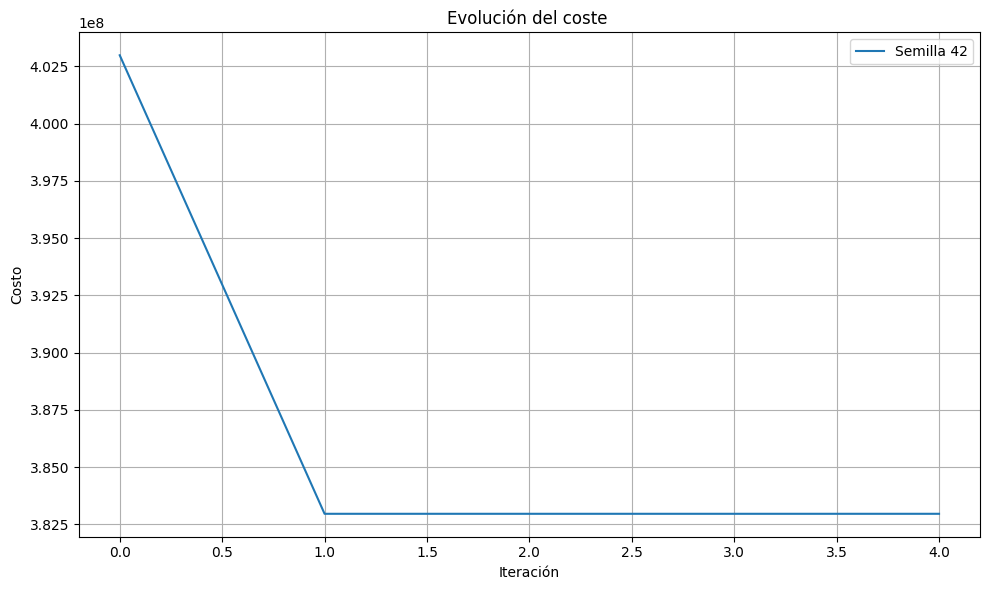

Ejecución 42: Mejor costo encontrado = 117442, Evaluaciones = 234689

Resumen del experimento :
Mejor coste: 117442


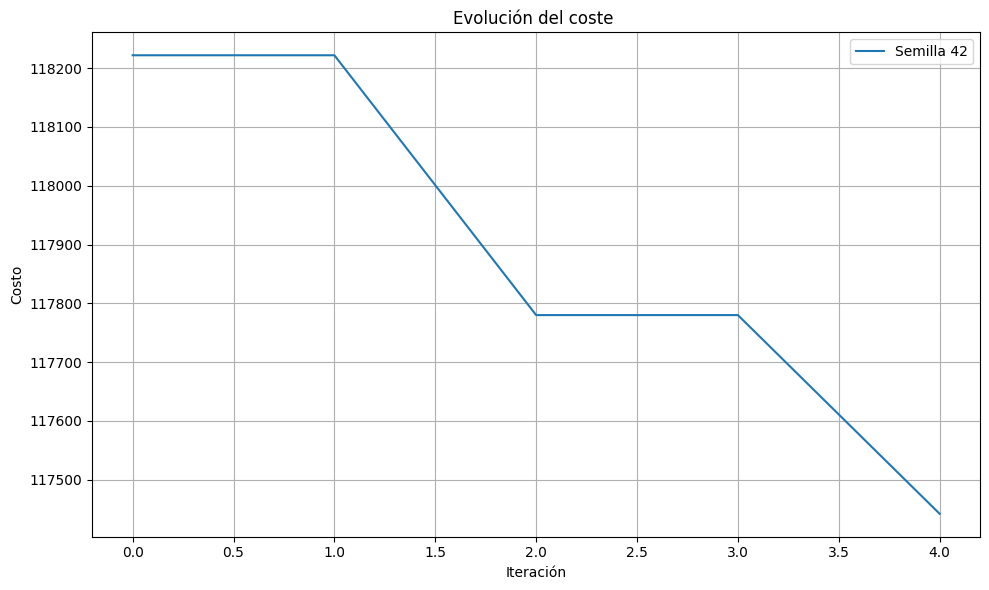

Ejecución 42: Mejor costo encontrado = 509533060, Evaluaciones = 944552

Resumen del experimento :
Mejor coste: 509533060


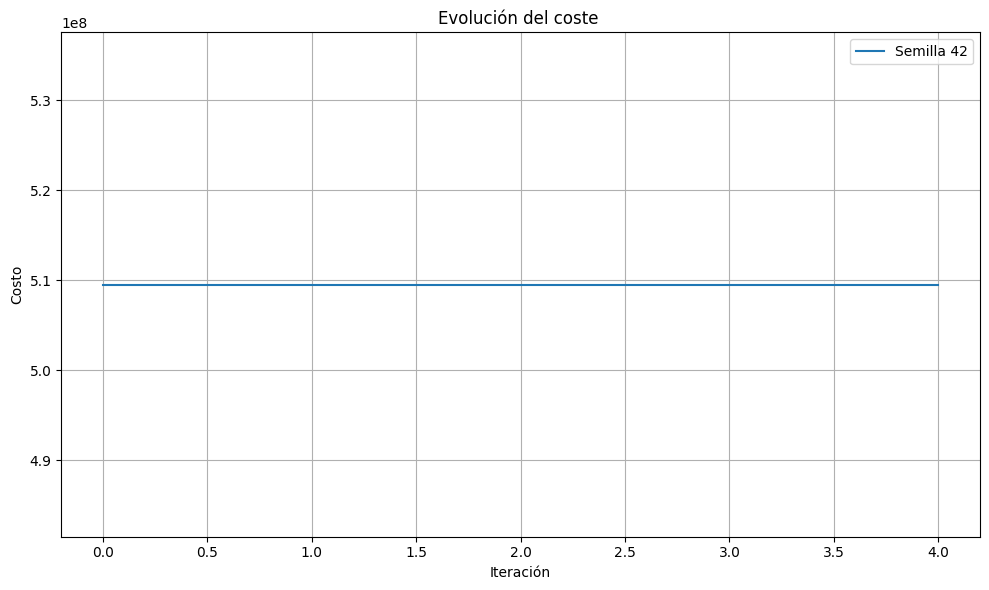

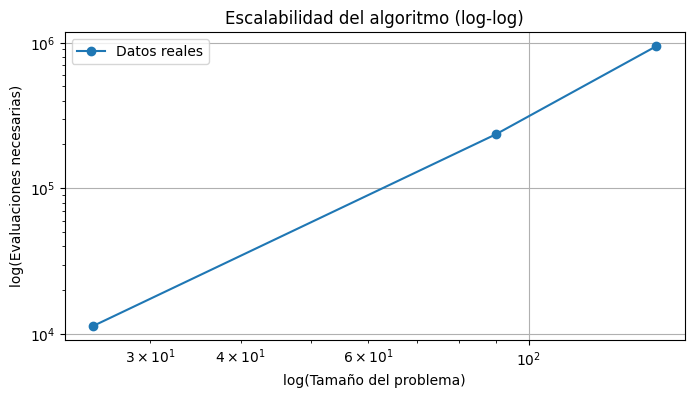

Pendiente (β) = 2.4462
Intercepto (α) = 0.6263


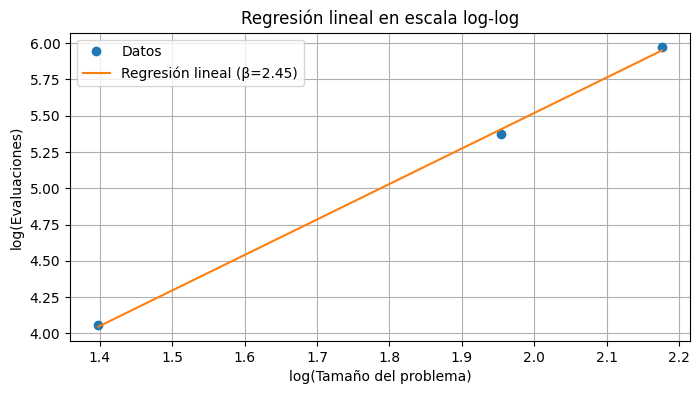

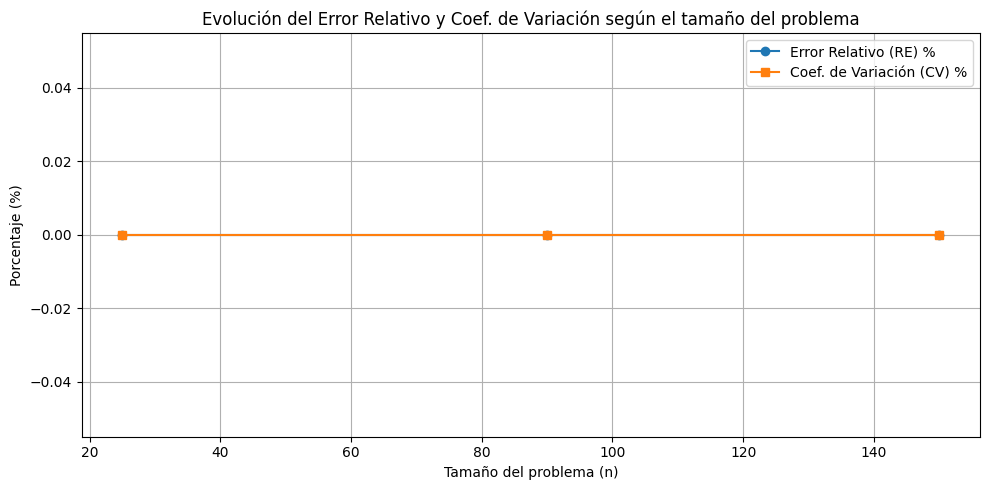

In [ ]:
b1,e1,h1=ejecutarExperimentoGrasp('/content/drive/MyDrive/Datos/tai25b.dat', seeds)
b2,e2,h2=ejecutarExperimentoGrasp('/content/drive/MyDrive/Datos/sko90.dat', seeds)
b3,e3,h3=ejecutarExperimentoGrasp('/content/drive/MyDrive/Datos/tai150b.dat', seeds)
tamaños = np.array([25, 90,150])
# Número de evaluaciones necesarias (ejemplo ficticio)
evaluaciones =[]
evaluaciones.append( max(e1))
evaluaciones.append( max(e2))
evaluaciones.append( max(e3))
# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.loglog(tamaños, evaluaciones, 'o-', label='Datos reales')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones necesarias)')
plt.title('Escalabilidad del algoritmo (log-log)')
plt.grid(True)
plt.legend()
plt.show()

log_sizes = np.log10(tamaños)
log_evals = np.log10(evaluaciones)

# Regresión lineal en escala log-log
slope, intercept = np.polyfit(log_sizes, log_evals, 1)
print(f"Pendiente (β) = {slope:.4f}")
print(f"Intercepto (α) = {intercept:.4f}")

# Para graficar la recta ajustada
x_fit = np.linspace(min(log_sizes), max(log_sizes), 100)
y_fit = slope * x_fit + intercept

# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.plot(log_sizes, log_evals, 'o', label='Datos')
plt.plot(x_fit, y_fit, '-', label=f'Regresión lineal (β={slope:.2f})')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones)')
plt.title('Regresión lineal en escala log-log')
plt.legend()
plt.grid(True)
plt.show()

mejores = np.array([min(b1), min(b2), min(b3)])
medias = np.array([np.mean(b1), np.mean(b2), np.mean(b3)])
stds = np.array([np.std(b1), np.std(b2), np.std(b3)])

# Cálculo de métricas
error_relativo = (medias - mejores) / mejores  # como proporción
cv = stds / medias  # como proporción

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(tamaños, error_relativo * 100, 'o-', label='Error Relativo (RE) %')
plt.plot(tamaños, cv * 100, 's-', label='Coef. de Variación (CV) %')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Porcentaje (%)')
plt.title('Evolución del Error Relativo y Coef. de Variación según el tamaño del problema')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def hamming_distance(sol1, sol2):
    if len(sol1) != len(sol2):
        raise ValueError("Las soluciones deben tener la misma longitud.")
    return sum(a != b for a, b in zip(sol1, sol2))

In [ ]:
def grasp(n, A, B, l=None, iteraciones=5):
    if l is None:
        l = max(1, int(0.1 * n))  # Al menos 1 para evitar listas vacías
    soluciones=[]
    mejor_solucion = None
    mejor_coste = float('inf')
    historial_costes = []
    total_evaluaciones = 0

    for _ in range(iteraciones):
        # Construir solución Greedy Aleatorizada
        solucion = construir_solucion_grasp(n, A, B, l)

        # Aplicar búsqueda local (primer mejor vecino)
        solucion_opt, coste_opt, evaluaciones, _ = busquedaLocalPrimerVecino(n, A, B,solucion,funcionObjetivo(solucion, A, B))
        soluciones.append(solucion_opt)
        total_evaluaciones += evaluaciones

        if coste_opt < mejor_coste:
            mejor_solucion = solucion_opt
            mejor_coste = coste_opt

        historial_costes.append(mejor_coste)
    distancias = []

    for i in range(len(soluciones)):
        for j in range(i + 1, len(soluciones)):
          d = hamming_distance(soluciones[i], soluciones[j])
          distancias.append((i + 1, j + 1, d))  # sumamos 1 para que empiece desde 1
    return mejor_solucion, mejor_coste, total_evaluaciones, historial_costes,soluciones,distancias

def grasp2(n, A, B, l=None, iteraciones=5):

    soluciones=[]
    mejor_solucion = None
    mejor_coste = float('inf')
    historial_costes = []
    total_evaluaciones = 0

    for _ in range(iteraciones):

        solucion = construir_solucion_grasp(n, A, B, l)

        soluciones.append(solucion)


    distancias = []
    for i in range(len(soluciones)):
        for j in range(i + 1, len(soluciones)):
          d = hamming_distance(soluciones[i], soluciones[j])
          distancias.append((i + 1, j + 1, d))  # sumamos 1 para que empiece desde 1
    return mejor_solucion, mejor_coste, total_evaluaciones, historial_costes,soluciones,distancias


In [ ]:
print("tai25b")
seed=seeds[0]
random.seed(seed)
np.random.seed(seed)
n, A, B = leerFichero('/content/drive/MyDrive/Datos/tai25b.dat')
mejor_sol, mejor_coste, evaluaciones, historial, soluciones, distancias = grasp(n, A, B, iteraciones=5)


for idx, (sol1, sol2, dist) in enumerate(distancias):
    print(f"Distancia {idx + 1}: Solución {sol1} con Solución {sol2} → {dist}")
soluciones_unicas = set()

for sol in soluciones:
    soluciones_unicas.add(tuple(sol))

cantidad_unicas = len(soluciones_unicas)
costes = [funcionObjetivo(sol, A, B) for sol in soluciones]

print(costes)
print(cantidad_unicas)
print("sko90")

seed=seeds[0]
random.seed(seed)
np.random.seed(seed)
n, A, B = leerFichero('/content/drive/MyDrive/Datos/sko90.dat')
mejor_sol, mejor_coste, evaluaciones, historial, soluciones, distancias = grasp(n, A, B, iteraciones=5)


for idx, (sol1, sol2, dist) in enumerate(distancias):
    print(f"Distancia {idx + 1}: Solución {sol1} con Solución {sol2} → {dist}")
soluciones_unicas = set()

for sol in soluciones:
    soluciones_unicas.add(tuple(sol))

cantidad_unicas = len(soluciones_unicas)
costes = [funcionObjetivo(sol, A, B) for sol in soluciones]

print(costes)
print(cantidad_unicas)
print("tai150b")
seed=seeds[0]
random.seed(seed)
np.random.seed(seed)

n, A, B = leerFichero('/content/drive/MyDrive/Datos/tai150b.dat')
mejor_sol, mejor_coste, evaluaciones, historial, soluciones, distancias = grasp(n, A, B, iteraciones=5)


for idx, (sol1, sol2, dist) in enumerate(distancias):
    print(f"Distancia {idx + 1}: Solución {sol1} con Solución {sol2} → {dist}")
soluciones_unicas = set()

for sol in soluciones:
    soluciones_unicas.add(tuple(sol))

cantidad_unicas = len(soluciones_unicas)
costes = [funcionObjetivo(sol, A, B) for sol in soluciones]

print(costes)
print(cantidad_unicas)

tai25b
Distancia 1: Solución 1 con Solución 2 → 24
Distancia 2: Solución 1 con Solución 3 → 25
Distancia 3: Solución 1 con Solución 4 → 23
Distancia 4: Solución 1 con Solución 5 → 25
Distancia 5: Solución 2 con Solución 3 → 23
Distancia 6: Solución 2 con Solución 4 → 24
Distancia 7: Solución 2 con Solución 5 → 25
Distancia 8: Solución 3 con Solución 4 → 23
Distancia 9: Solución 3 con Solución 5 → 14
Distancia 10: Solución 4 con Solución 5 → 22
[402987218, 382956263, 406742811, 411210374, 396120306]
5
sko90
Distancia 1: Solución 1 con Solución 2 → 87
Distancia 2: Solución 1 con Solución 3 → 88
Distancia 3: Solución 1 con Solución 4 → 88
Distancia 4: Solución 1 con Solución 5 → 88
Distancia 5: Solución 2 con Solución 3 → 85
Distancia 6: Solución 2 con Solución 4 → 86
Distancia 7: Solución 2 con Solución 5 → 88
Distancia 8: Solución 3 con Solución 4 → 83
Distancia 9: Solución 3 con Solución 5 → 88
Distancia 10: Solución 4 con Solución 5 → 86
[118222, 118928, 117780, 117858, 117442]
5
tai1

In [ ]:
print("tai25b")
seed=seeds[0]
random.seed(seed)
np.random.seed(seed)
n, A, B = leerFichero('/content/drive/MyDrive/Datos/tai25b.dat')
mejor_sol, mejor_coste, evaluaciones, historial, soluciones, distancias = grasp2(n, A, B, iteraciones=5)


for idx, (sol1, sol2, dist) in enumerate(distancias):
    print(f"Distancia {idx + 1}: Solución {sol1} con Solución {sol2} → {dist}")
soluciones_unicas = set()

for sol in soluciones:
    soluciones_unicas.add(tuple(sol))
costes = [funcionObjetivo(sol, A, B) for sol in soluciones]

print(costes)
cantidad_unicas = len(soluciones_unicas)
print(cantidad_unicas)
print("sko90")

seed=seeds[0]
random.seed(seed)
np.random.seed(seed)
n, A, B = leerFichero('/content/drive/MyDrive/Datos/sko90.dat')
mejor_sol, mejor_coste, evaluaciones, historial, soluciones, distancias = grasp2(n, A, B, iteraciones=5)


for idx, (sol1, sol2, dist) in enumerate(distancias):
    print(f"Distancia {idx + 1}: Solución {sol1} con Solución {sol2} → {dist}")
soluciones_unicas = set()

for sol in soluciones:
    soluciones_unicas.add(tuple(sol))
costes = [funcionObjetivo(sol, A, B) for sol in soluciones]

print(costes)
cantidad_unicas = len(soluciones_unicas)
print(cantidad_unicas)
print("tai150b")
seed=seeds[0]
random.seed(seed)
np.random.seed(seed)

n, A, B = leerFichero('/content/drive/MyDrive/Datos/tai150b.dat')
mejor_sol, mejor_coste, evaluaciones, historial, soluciones, distancias = grasp2(n, A, B, iteraciones=5)


for idx, (sol1, sol2, dist) in enumerate(distancias):
    print(f"Distancia {idx + 1}: Solución {sol1} con Solución {sol2} → {dist}")
soluciones_unicas = set()

for sol in soluciones:
    soluciones_unicas.add(tuple(sol))
costes = [funcionObjetivo(sol, A, B) for sol in soluciones]

print(costes)
cantidad_unicas = len(soluciones_unicas)
print(cantidad_unicas)

tai25b
Distancia 1: Solución 1 con Solución 2 → 25
Distancia 2: Solución 1 con Solución 3 → 23
Distancia 3: Solución 1 con Solución 4 → 24
Distancia 4: Solución 1 con Solución 5 → 24
Distancia 5: Solución 2 con Solución 3 → 25
Distancia 6: Solución 2 con Solución 4 → 23
Distancia 7: Solución 2 con Solución 5 → 21
Distancia 8: Solución 3 con Solución 4 → 24
Distancia 9: Solución 3 con Solución 5 → 25
Distancia 10: Solución 4 con Solución 5 → 23
[744793048, 892673166, 895305552, 946857897, 887232560]
5
sko90
Distancia 1: Solución 1 con Solución 2 → 88
Distancia 2: Solución 1 con Solución 3 → 90
Distancia 3: Solución 1 con Solución 4 → 90
Distancia 4: Solución 1 con Solución 5 → 88
Distancia 5: Solución 2 con Solución 3 → 89
Distancia 6: Solución 2 con Solución 4 → 89
Distancia 7: Solución 2 con Solución 5 → 87
Distancia 8: Solución 3 con Solución 4 → 90
Distancia 9: Solución 3 con Solución 5 → 90
Distancia 10: Solución 4 con Solución 5 → 87
[137586, 136370, 137656, 137562, 136704]
5
tai1

In [18]:
def ils_poblacional(n, A, B, tam_poblacion=5, iteraciones=10, l=3, rb=5, no_mejora_max=3):

    poblacion = [np.random.permutation(n) for _ in range(tam_poblacion)]
    costes = [funcionObjetivo(sol, A, B) for sol in poblacion]
    total_evaluaciones = 0

    # BL inicial
    for i in range(tam_poblacion):
        poblacion[i], costes[i], evaluaciones, _ = busquedaLocalPrimerVecino(
            n, A, B, poblacion[i], funcionObjetivo(poblacion[i], A, B)
        )
        total_evaluaciones += evaluaciones

    idx_mejor = np.argmin(costes)
    mejor_solucion = poblacion[idx_mejor].copy()
    mejor_coste = costes[idx_mejor]

    historial_costes = [mejor_coste]
    trayectoria = [mejor_solucion.copy()]  # Guardamos la trayectoria de soluciones

    longitud_sin_mejora = 0
    longitud_antes_estancamiento = None

    for it in range(1, iteraciones + 1):
        mejora_esta_iteracion = False
        for i in range(tam_poblacion):
            mutada = mutar_sublista(poblacion[i], n // 4)
            mutada_bl, coste_bl, evaluaciones, _ = busquedaLocalPrimerVecino(
                n, A, B, mutada, funcionObjetivo(mutada, A, B)
            )
            total_evaluaciones += evaluaciones

            if coste_bl < costes[i]:
                poblacion[i] = mutada_bl
                costes[i] = coste_bl

        # Reemplazo del peor por la mejor
        if it % rb == 0:
            idx_peor = np.argmax(costes)
            poblacion[idx_peor] = mejor_solucion.copy()
            costes[idx_peor] = mejor_coste

        # Comprobar si hay mejora global
        idx_actual = np.argmin(costes)
        if costes[idx_actual] < mejor_coste:
            mejor_coste = costes[idx_actual]
            mejor_solucion = poblacion[idx_actual].copy()
            mejora_esta_iteracion = True
            longitud_sin_mejora = 0
        else:
            longitud_sin_mejora += 1

        historial_costes.append(mejor_coste)
        trayectoria.append(mejor_solucion.copy())

        if longitud_antes_estancamiento is None and longitud_sin_mejora >= no_mejora_max:
            longitud_antes_estancamiento = it - no_mejora_max

    if longitud_antes_estancamiento is None:
        longitud_antes_estancamiento = iteraciones

    return (
        mejor_solucion,
        mejor_coste,
        total_evaluaciones,
        historial_costes,
        longitud_antes_estancamiento,
        trayectoria,
        costes
    )


def graficar_trayectoria(historial_costes, trayectoria):
    def distancia_hamming(sol1, sol2):
        return np.sum(np.array(sol1) != np.array(sol2))

    # 1. Evolución del coste
    plt.figure(figsize=(10, 4))
    plt.plot(historial_costes, marker='o')
    plt.title("Evolución del coste de la mejor solución")
    plt.xlabel("Iteración")
    plt.ylabel("Coste")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    distancias = [
        distancia_hamming(trayectoria[i], trayectoria[i + 1])
        for i in range(len(trayectoria) - 1)
    ]

    plt.figure(figsize=(10, 4))
    plt.plot(distancias, marker='s', color='orange')
    plt.title("Distancia de Hamming entre soluciones sucesivas")
    plt.xlabel("Iteración")
    plt.ylabel("Hamming")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def analizar_overlap(soluciones_finales, costes_finales):
    n = len(soluciones_finales)
    distancias = []

    for i in range(n):
        for j in range(i + 1, n):
            d = hamming_distance(soluciones_finales[i], soluciones_finales[j])
            distancias.append(d)

    media_dist = np.mean(distancias)
    std_costes = np.std(costes_finales)

    print("🔍 OVERLAP ENTRE SOLUCIONES FINALES (CONVERGENCIA)")
    print(f"- Distancia Hamming media entre soluciones finales: {media_dist:.2f}")
    print(f"- Desviación estándar de los costes finales: {std_costes:.2f}")

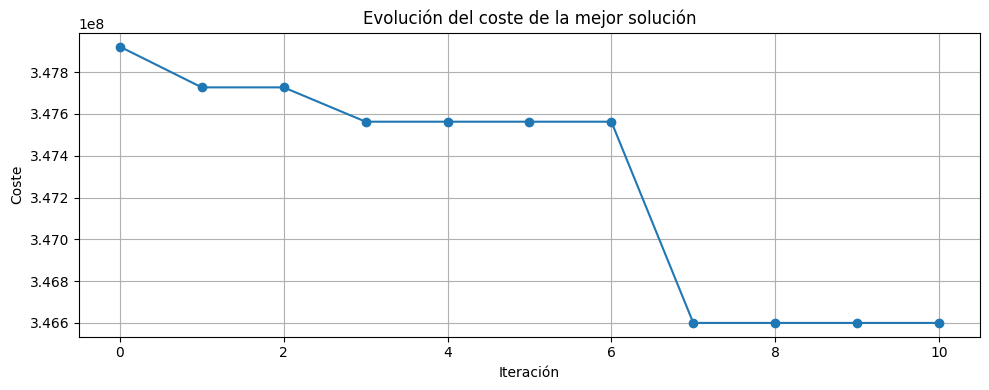

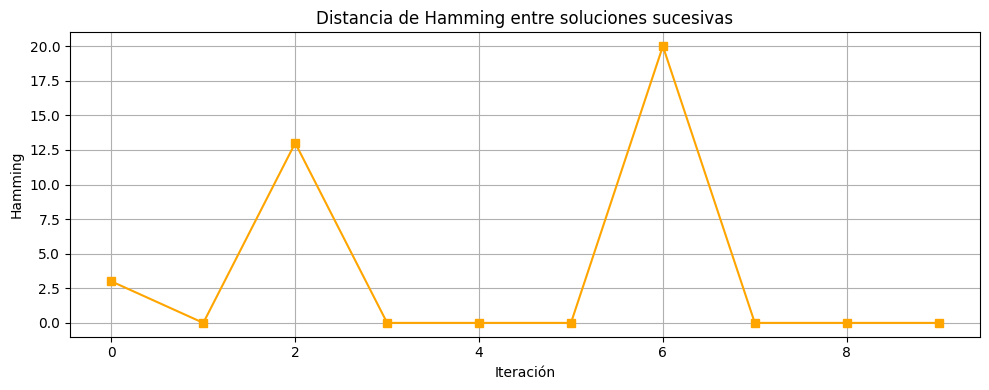

Semilla 42 → Longitud antes de estancamiento: 3  Mejor coste 346600084
Distancia Hamming media: 3.6
Saltos entre óptimos locales (iteraciones): [1, 2, 4]

Media de la longitud de trayectorias antes de estancamiento: 3.00


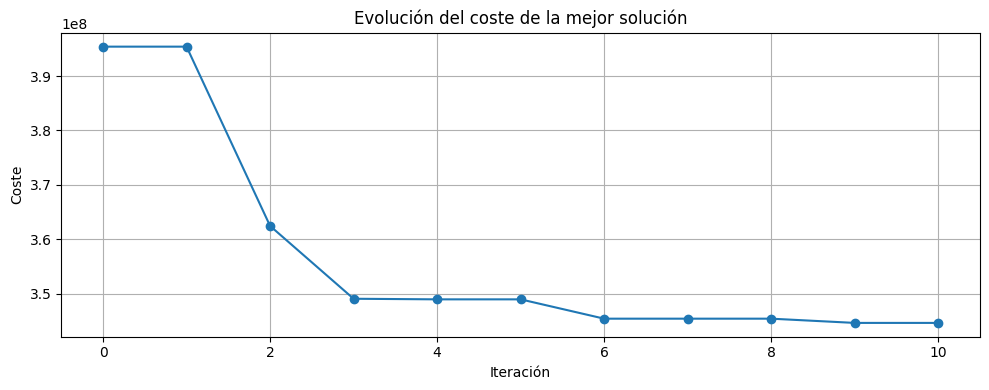

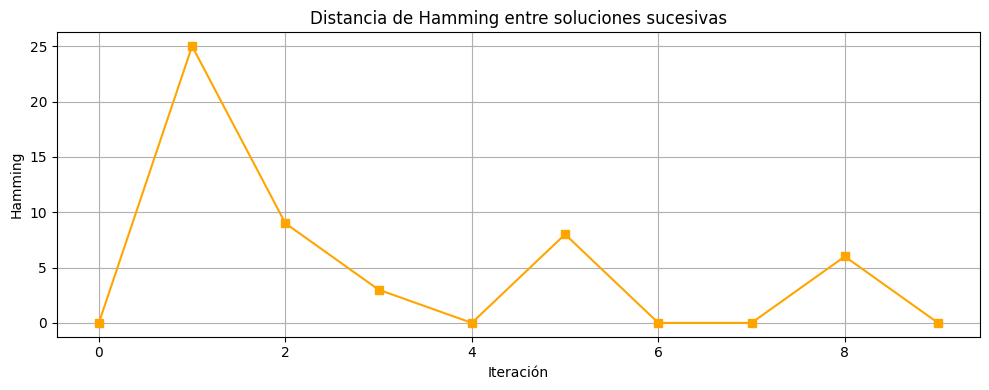

Semilla 9914 → Longitud antes de estancamiento: 10  Mejor coste 344630861
Distancia Hamming media: 5.1
Saltos entre óptimos locales (iteraciones): [2, 1, 1, 2, 3]

Media de la longitud de trayectorias antes de estancamiento: 6.50


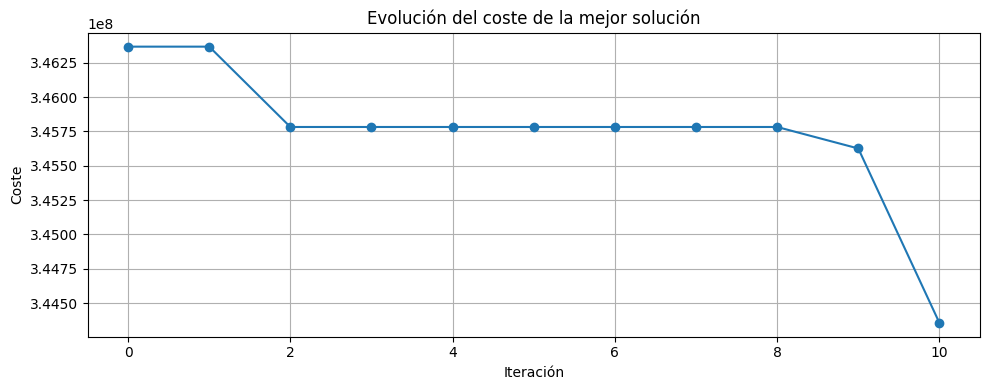

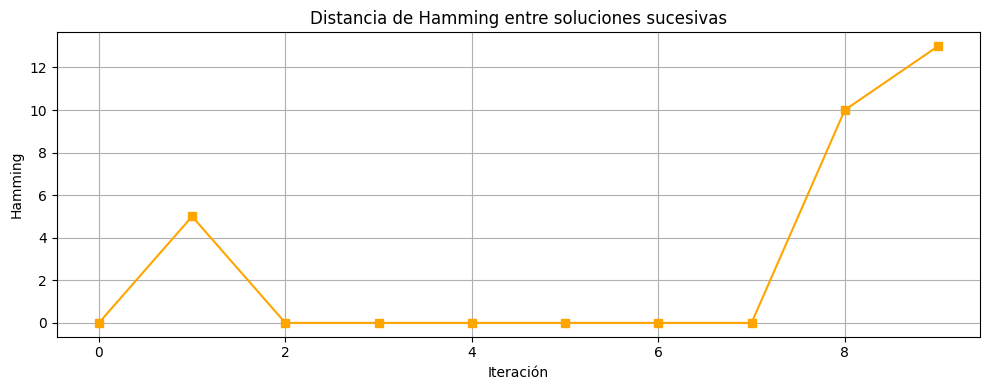

Semilla 123459 → Longitud antes de estancamiento: 2  Mejor coste 344355646
Distancia Hamming media: 2.8
Saltos entre óptimos locales (iteraciones): [2, 7, 1]

Media de la longitud de trayectorias antes de estancamiento: 5.00


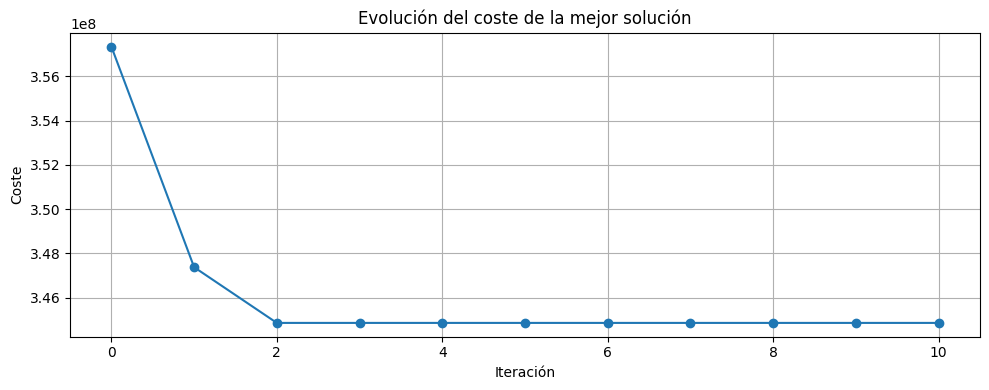

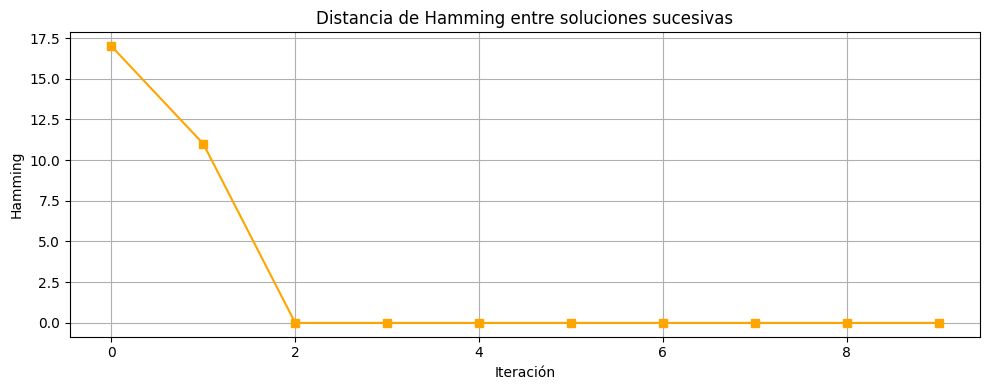

Semilla 5444663 → Longitud antes de estancamiento: 2  Mejor coste 344855160
Distancia Hamming media: 2.8
Saltos entre óptimos locales (iteraciones): [1, 1]

Media de la longitud de trayectorias antes de estancamiento: 4.25


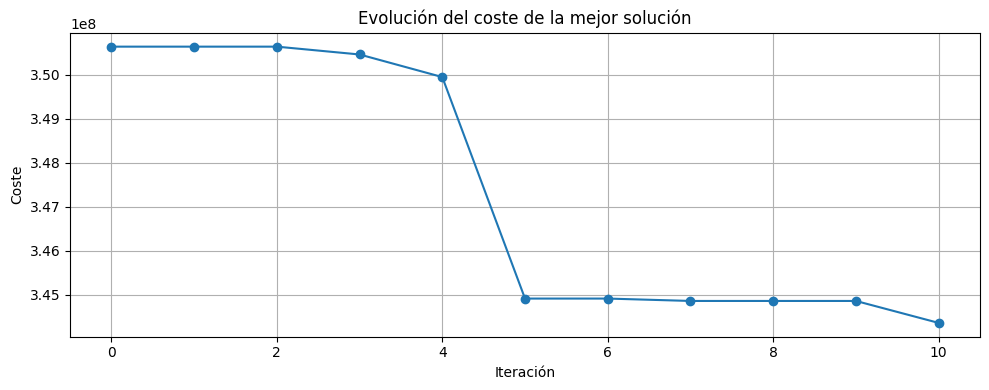

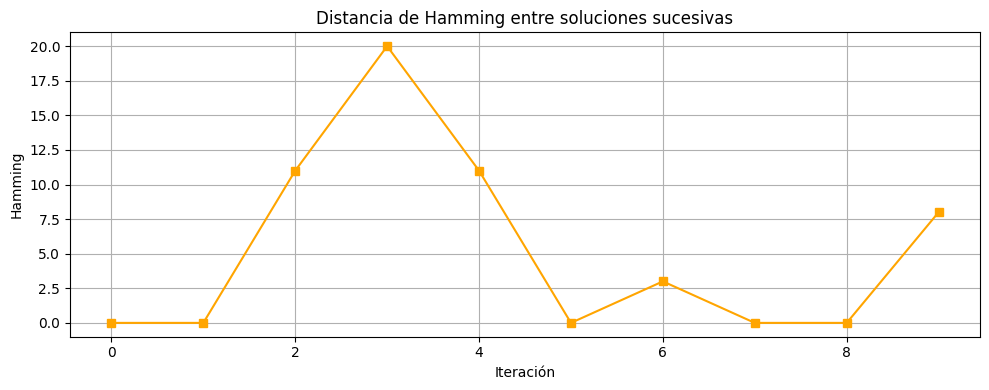

Semilla 33893 → Longitud antes de estancamiento: 10  Mejor coste 344355646
Distancia Hamming media: 5.3
Saltos entre óptimos locales (iteraciones): [3, 1, 1, 2, 3]

Media de la longitud de trayectorias antes de estancamiento: 5.40
🔍 OVERLAP ENTRE SOLUCIONES FINALES (CONVERGENCIA)
- Distancia Hamming media entre soluciones finales: 10.20
- Desviación estándar de los costes finales: 841389.99


In [20]:
def ejecutar_varias_ils(n, A, B, seeds):
  soluciones = []
  costes = []



  longitudes = []

  for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    sol, coste, evs, costes_hist, estancamiento, trayectoria,costesFin = ils_poblacional(n, A, B, tam_poblacion=5, iteraciones=10, l=3, rb=5, no_mejora_max=3)
    longitudes.append(estancamiento)
    graficar_trayectoria(costes_hist, trayectoria)
    print(f"Semilla {seed} → Longitud antes de estancamiento: {estancamiento}  Mejor coste {coste}")
    hamming_sucesiva = [
    hamming_distance(trayectoria[i], trayectoria[i+1])
    for i in range(len(trayectoria) - 1)
    ]
    soluciones.append(sol)
    costes.append(coste)

# Detección de saltos de óptimos locales
    saltos = []
    last_mejora_idx = 0
    for i, c in enumerate(costes_hist):
       if c < costes_hist[last_mejora_idx]:
        saltos.append(i - last_mejora_idx)
        last_mejora_idx = i

# Resultado
    print("Distancia Hamming media:", np.mean(hamming_sucesiva))
    print("Saltos entre óptimos locales (iteraciones):", saltos)


    media_L = np.mean(longitudes)
    print(f"\nMedia de la longitud de trayectorias antes de estancamiento: {media_L:.2f}")
  return soluciones, costes
n, A, B = leerFichero('tai25b.dat')
sols, costes = ejecutar_varias_ils(n, A, B, seeds)
analizar_overlap(sols, costes)




In [ ]:

def vns_experimento(n, A, B, kmax=5):
    S = np.random.permutation(n)
    C = funcionObjetivo(S, A, B)
    total_evaluaciones = 0
    trayectorias=[S]
    historial_costes = [C]
    historial_k = [1]
    vecindarios_por_mejora = []
    evaluaciones_por_vecindario = []

    k = 1
    vecindarios_sin_mejora = 0
    vecindarios_actuales = 0

    while k <= kmax:
        s = max(1, n // (9 - k))
        S_prim = generar_vecino_por_sublista(S, s)

        C_prim = funcionObjetivo(S_prim, A, B)
        S_mejorado, C_mejorado, evaluaciones, _ = busquedaLocalPrimerVecino(n, A, B, S_prim, C_prim)
        total_evaluaciones += evaluaciones

        evaluaciones_por_vecindario.append(evaluaciones)

        historial_k.append(k)
        vecindarios_actuales += 1

        if C_mejorado < C:
            historial_costes.append(C)
            S = S_mejorado
            trayectorias.append(S)
            C = C_mejorado
            vecindarios_por_mejora.append(vecindarios_actuales)
            vecindarios_actuales = 0
            k = 1
        else:
            k += 1

    return {
        'solucion': S,
        'coste': C,
        'evaluaciones_totales': total_evaluaciones,
        'costes': historial_costes,
        'vecindarios_por_mejora': vecindarios_por_mejora,
        'evaluaciones_por_vecindario': evaluaciones_por_vecindario,
        'historial_k': historial_k,
        'historial_trayectoria': trayectorias

    }
def graficar_vns_resultados(resultado):
    costos = resultado['costes']
    evaluaciones = resultado['evaluaciones_por_vecindario']
    ks = resultado['historial_k']

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(costos, marker='o')
    axs[0].set_ylabel('Coste')
    axs[0].set_title('Evolución del coste (fitness) en VNS')
    axs[0].grid(True)

    axs[1].bar(range(len(evaluaciones)), evaluaciones)
    axs[1].set_xlabel('Cambio de vecindario')
    axs[1].set_ylabel('Evaluaciones')
    axs[1].set_title('Evaluaciones realizadas en cada vecindario')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    print("Vecindarios explorados antes de mejorar:", resultado['vecindarios_por_mejora'])
    print("Evaluaciones totales:", resultado['evaluaciones_totales'])
    print("Número de mejoras:", len(resultado['vecindarios_por_mejora']))
    hamming_promedio_en_trayectoria(resultado['historial_trayectoria'])

def hamming_promedio_en_trayectoria(trayectoria):
    distancias = []
    for i in range(1, len(trayectoria)):
        d = hamming_distance(trayectoria[i - 1], trayectoria[i])
        distancias.append(d)

    if distancias:
        media = np.mean(distancias)
        print(f"Distancia de Hamming promedio entre iteraciones: {media:.2f}")
    else:
        print("No hay suficientes soluciones en la trayectoria para calcular distancias.")

    return distancias

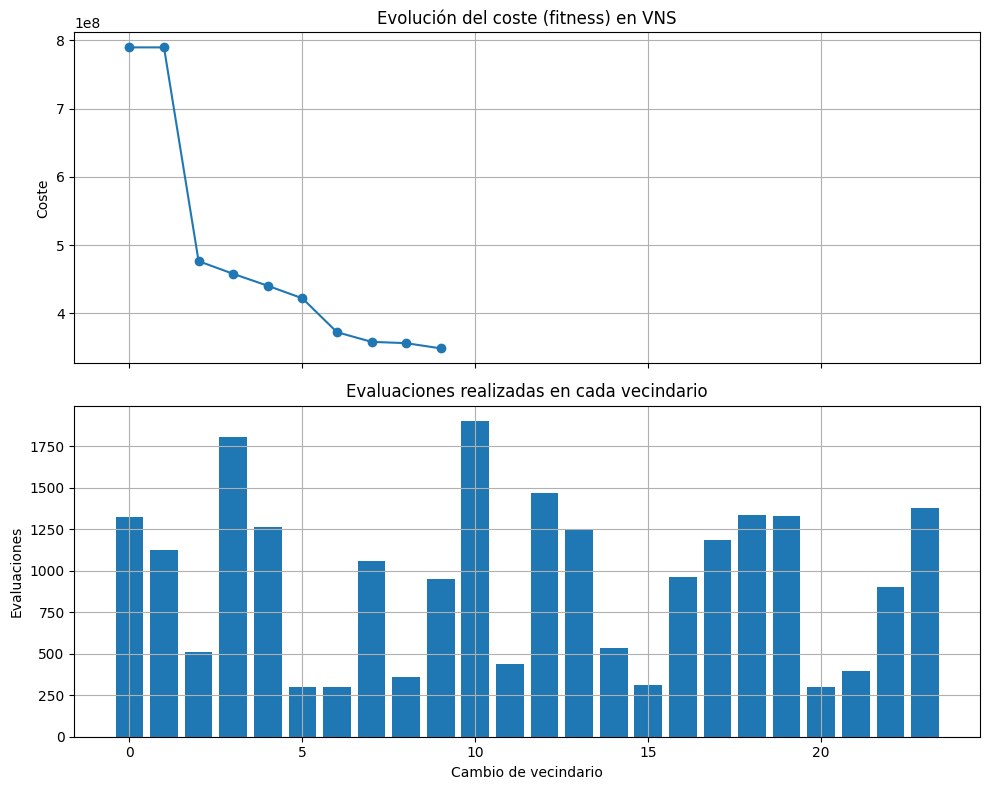

Vecindarios explorados antes de mejorar: [1, 4, 3, 2, 3, 1, 3, 1, 1]
Evaluaciones totales: 22678
Número de mejoras: 9
Distancia de Hamming promedio entre iteraciones: 14.89


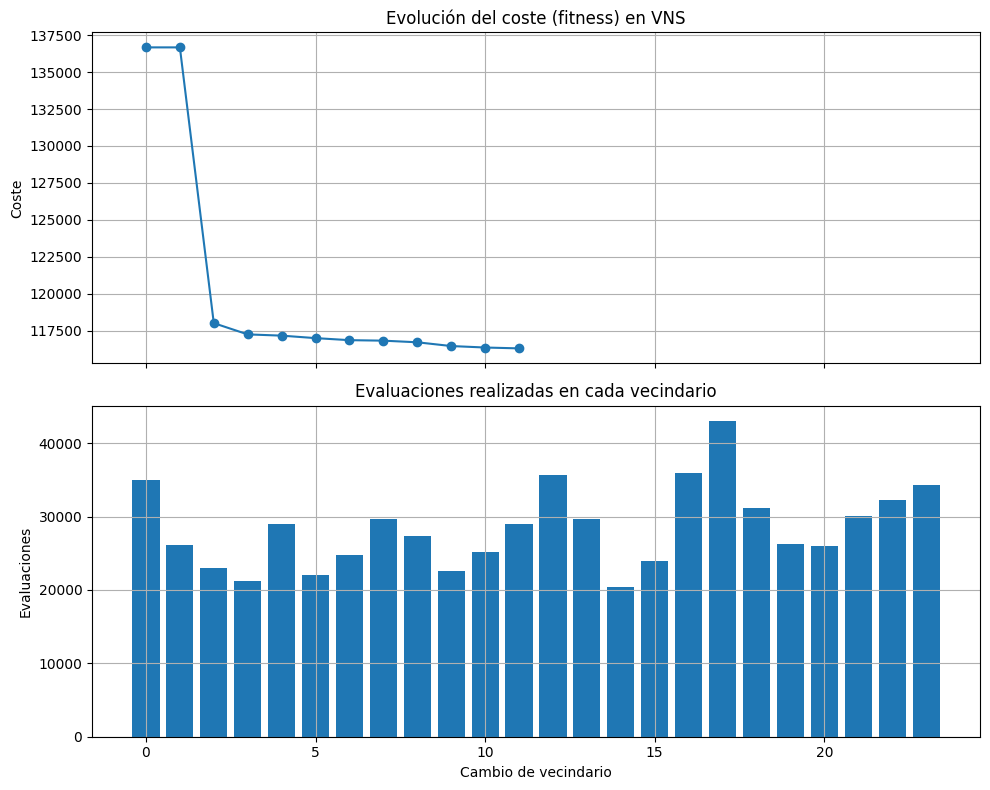

Vecindarios explorados antes de mejorar: [1, 1, 2, 1, 2, 1, 1, 4, 1, 4, 1]
Evaluaciones totales: 683205
Número de mejoras: 11
Distancia de Hamming promedio entre iteraciones: 48.55


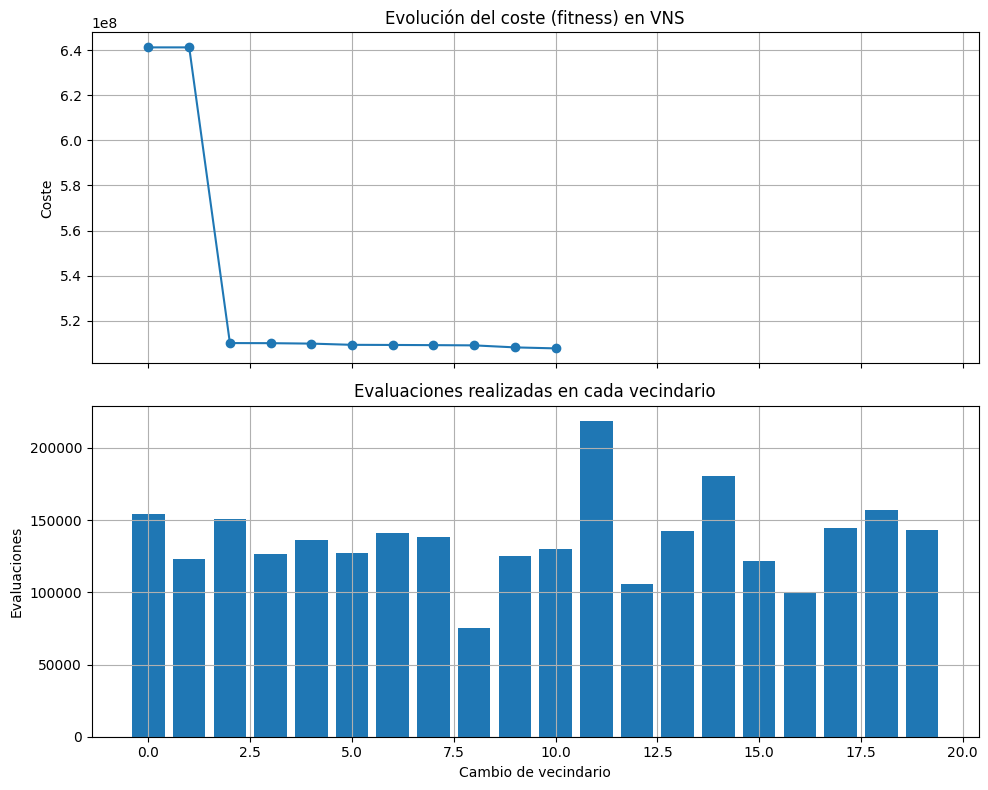

Vecindarios explorados antes de mejorar: [1, 1, 1, 1, 1, 1, 1, 4, 1, 3]
Evaluaciones totales: 2739000
Número de mejoras: 10
Distancia de Hamming promedio entre iteraciones: 92.80


In [ ]:

n, A, B = leerFichero('tai25b.dat')
res = vns_experimento(n, A, B)
graficar_vns_resultados(res)


n, A, B = leerFichero('sko90.dat')
res = vns_experimento(n, A, B)
graficar_vns_resultados(res)


n, A, B = leerFichero('tai150b.dat')
res = vns_experimento(n, A, B)
graficar_vns_resultados(res)
